In [35]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np

In [36]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_curve
import itertools

In [38]:
import warnings

In [39]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [40]:
# read the merged data
mod_data = pd.read_parquet('../Clean_Data/Model_Data/Features_w_Label_downsampled.parquet')
#Eval_data = pd.read_parquet('../Clean_Data/Model_Data/Features_w_Label_2023_OOT.parquet')

category # removed; 
wind_from_direction
type

In [41]:
mod_data.head()

,day,dead_fuel_moisture_1000hr,dead_fuel_moisture_100hr,pdsi,category,air_temperature_x,relative_humidity_x,max_wind_speed,air_temperature_y,relative_humidity_y,precipitation_amount,specific_humidity,surface_downwelling_shortwave_flux_in_air,wind_from_direction,wind_speed,IS_FIRE,type,slope_avg,slope_max
0,2001-11-24,29.700001,25.600000,-2.690001,3.0,288.3,100.0,10.600000,279.6,59.100002,40.200001,0.00613,65.500000,277.0,8.300000,0,7.0,15.075278,33.0
1,2002-06-26,17.500000,16.300001,-2.430000,3.0,293.5,100.0,7.800000,283.6,54.299999,NaN,0.00842,355.300018,335.0,4.400000,0,7.0,15.075278,33.0
2,2002-08-25,16.800001,17.300001,-2.810000,3.0,293.6,100.0,8.700000,283.8,53.900002,NaN,0.00808,261.399994,351.0,7.400000,0,7.0,15.075278,33.0
3,2002-09-29,17.000000,17.400000,-2.950000,3.0,293.6,100.0,9.500000,282.1,47.000000,NaN,0.00709,200.000000,358.0,6.500000,0,7.0,15.075278,33.0
4,2003-12-28,31.500000,24.400000,-1.630000,4.0,284.3,100.0,11.900001,277.6,63.200001,28.000000,0.00585,31.100000,193.0,11.900001,0,7.0,15.075278,33.0


In [44]:
# column 'type' unique values
mod_data['type'].nunique()

39

In [9]:
Eval_data.dtypes == mod_data.dtypes

day                                          True
dead_fuel_moisture_1000hr                    True
dead_fuel_moisture_100hr                     True
pdsi                                         True
category                                     True
air_temperature_x                            True
relative_humidity_x                          True
max_wind_speed                               True
air_temperature_y                            True
relative_humidity_y                          True
precipitation_amount                         True
specific_humidity                            True
surface_downwelling_shortwave_flux_in_air    True
wind_from_direction                          True
wind_speed                                   True
IS_FIRE                                      True
type                                         True
slope_avg                                    True
slope_max                                    True
dtype: bool

In [10]:
# one hot encoding for 'type'
mod_data = pd.get_dummies(mod_data, columns=['type'])
Eval_data = pd.get_dummies(Eval_data, columns=['type'])

In [11]:
# check the % IS_FIRE
mod_data['IS_FIRE'].value_counts(normalize=True)

IS_FIRE
0    0.990099
1    0.009901
Name: proportion, dtype: float64

In [12]:
# Split data into train, validation, and out-of-time (OOT) sets
oot_data_downsampled = mod_data[mod_data['day'] > '2023-01-01']
train_val_data = mod_data[mod_data['day'] <= '2023-01-01']

In [13]:
Eval_data['day'].min(), Eval_data['day'].max()

(Timestamp('2023-01-02 00:00:00'), Timestamp('2023-12-31 00:00:00'))

In [14]:
oot_data_downsampled['day'].min(), oot_data_downsampled['day'].max()

(Timestamp('2023-04-06 00:00:00'), Timestamp('2023-12-31 00:00:00'))

In [15]:
train_val_data['day'].min(), train_val_data['day'].max()

(Timestamp('2001-01-03 00:00:00'), Timestamp('2022-12-31 00:00:00'))

In [16]:
# check the range of day in mod_data
mod_data['day'].min(), mod_data['day'].max()

(Timestamp('2001-01-03 00:00:00'), Timestamp('2023-12-31 00:00:00'))

In [17]:
oot_data_downsampled['IS_FIRE'].value_counts()

IS_FIRE
0    28167
1      228
Name: count, dtype: int64

In [18]:
Eval_data['IS_FIRE'].value_counts()

IS_FIRE
0    5834748
1        228
Name: count, dtype: int64

In [20]:
# Further split train_val_data into train and validation sets
train_data, val_data = train_test_split(train_val_data, test_size=0.3, shuffle=True, random_state=42)

# Separate features and labels
X_train = train_data.drop(columns=['IS_FIRE', 'day'])
y_train = train_data['IS_FIRE']
X_val = val_data.drop(columns=['IS_FIRE', 'day'])
y_val = val_data['IS_FIRE']
X_oot_downsampled = oot_data_downsampled.drop(columns=['IS_FIRE', 'day'])
y_oot_downsampled = oot_data_downsampled['IS_FIRE']
X_oot = Eval_data.drop(columns=['IS_FIRE', 'day'])
y_oot = Eval_data['IS_FIRE']

In [22]:
def evaluate_model(model, X_eval, y_eval):
    # Predict on evaluation data
    y_eval_pred = model.predict_proba(X_eval)[:, 1]

    # Calculate ROC AUC on evaluation data
    roc_auc = roc_auc_score(y_eval, y_eval_pred)
    print(f'ROC AUC on evaluation data: {roc_auc}')

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_eval, y_eval_pred)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

1. Train a model (without any parameter tuning)

In [21]:
# Train XGBoost model
mod_1 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
mod_1.fit(X_train, y_train)

c:\Users\fangshuye\AppData\Local\anaconda3\envs\py311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:45:25] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

ROC AUC on evaluation data: 0.7904190950091528


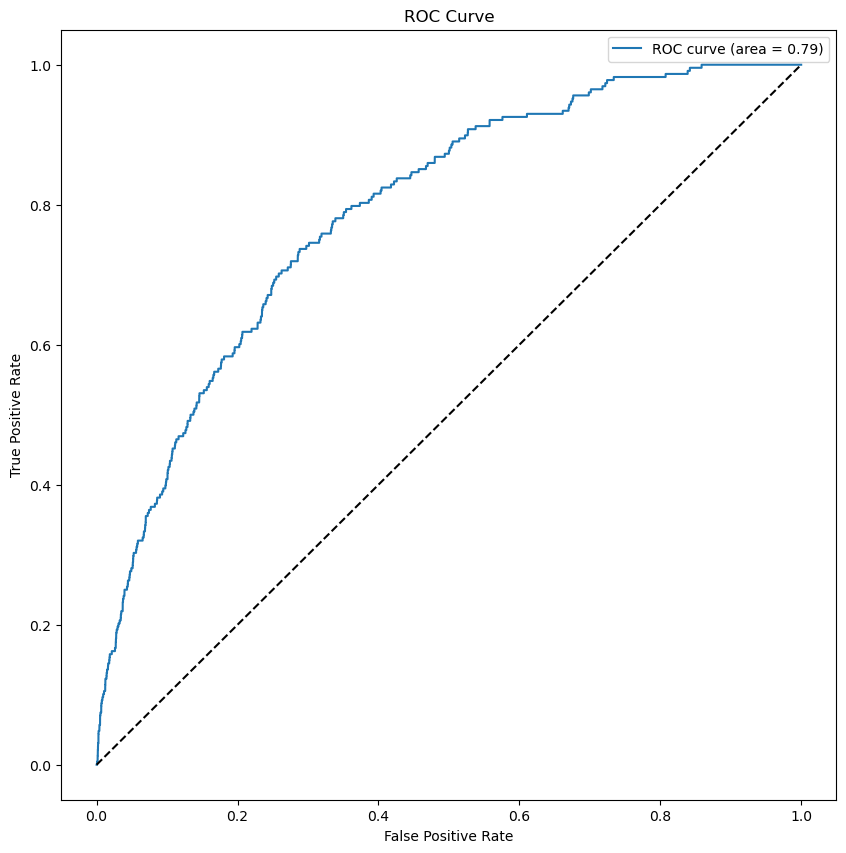

In [26]:
evaluate_model(mod_1, X_oot_downsampled, y_oot_downsampled)

US Drought monitor classifications for standardized Palmer drought indices

ROC AUC on evaluation data: 0.8278422439483213


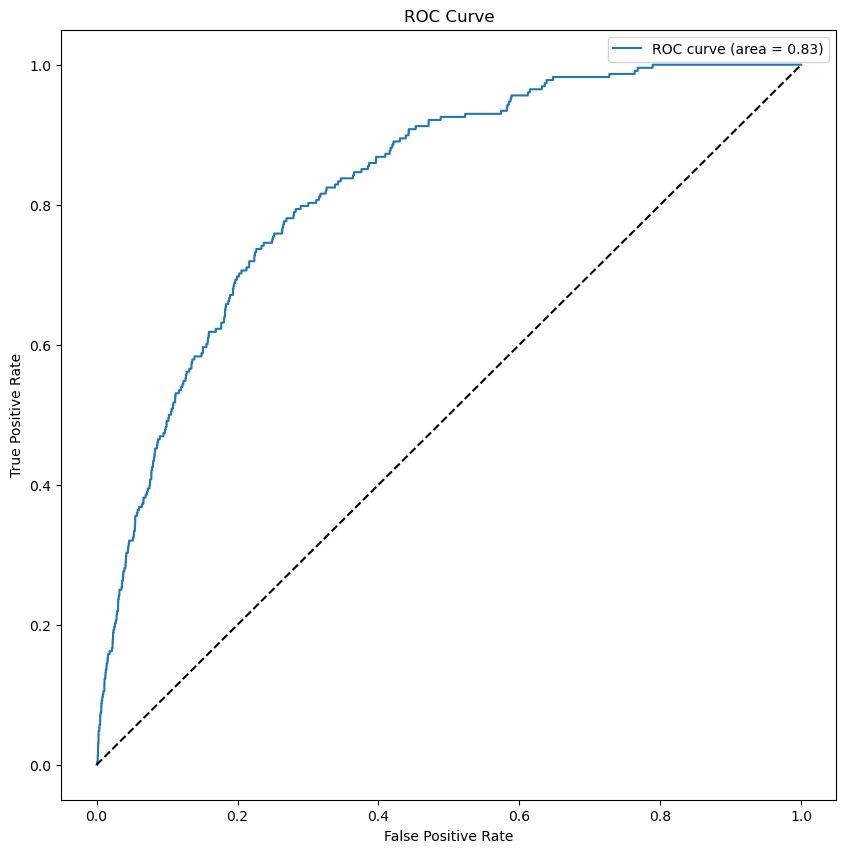

In [27]:
evaluate_model(mod_1, X_oot, y_oot)

precision-recall

2. Train the best model using parameter tuning

In [29]:
# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Generate all combinations of parameters
param_combinations = list(itertools.product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['subsample']
))

best_auc = 0
best_params = None

warnings.filterwarnings('ignore')
for params in param_combinations:
    n_estimators, max_depth, learning_rate, subsample = params
    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    model.fit(X_train, y_train)
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    print(f'Params: {params}, AUC: {auc}')
    if auc > best_auc:
        best_auc = auc
        best_params = params

print(f'Best Params: {best_params}, Best AUC: {best_auc}')

Params: (50, 3, 0.01, 0.8), AUC: 0.7379698533624404
Params: (50, 3, 0.01, 1.0), AUC: 0.7311590363633279
Params: (50, 3, 0.1, 0.8), AUC: 0.7635404073100873
Params: (50, 3, 0.1, 1.0), AUC: 0.7636346199809325
Params: (50, 3, 0.2, 0.8), AUC: 0.7769360210241615
Params: (50, 3, 0.2, 1.0), AUC: 0.7755447887677567
Params: (50, 4, 0.01, 0.8), AUC: 0.7504980321889254
Params: (50, 4, 0.01, 1.0), AUC: 0.7443595053179144
Params: (50, 4, 0.1, 0.8), AUC: 0.7724648629073192
Params: (50, 4, 0.1, 1.0), AUC: 0.7702475988205714
Params: (50, 4, 0.2, 0.8), AUC: 0.7833548393737628
Params: (50, 4, 0.2, 1.0), AUC: 0.7822517253168768
Params: (50, 5, 0.01, 0.8), AUC: 0.756600187042621
Params: (50, 5, 0.01, 1.0), AUC: 0.7486669085696603
Params: (50, 5, 0.1, 0.8), AUC: 0.7795855365268632
Params: (50, 5, 0.1, 1.0), AUC: 0.7769324515650713
Params: (50, 5, 0.2, 0.8), AUC: 0.7880860981044662
Params: (50, 5, 0.2, 1.0), AUC: 0.7852979384663141
Params: (100, 3, 0.01, 0.8), AUC: 0.744127131752343
Params: (100, 3, 0.01, 1.

In [30]:
# Train the best model on the full training data
best_model = xgb.XGBClassifier(
    n_estimators=best_params[0],
    max_depth=best_params[1],
    learning_rate=best_params[2],
    subsample=best_params[3],
    use_label_encoder=False,
    eval_metric='logloss'
)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [34]:
# save the best model
best_model.save_model('../Model/xgb_model.json')

ROC AUC on evaluation data: 0.7897955427497275


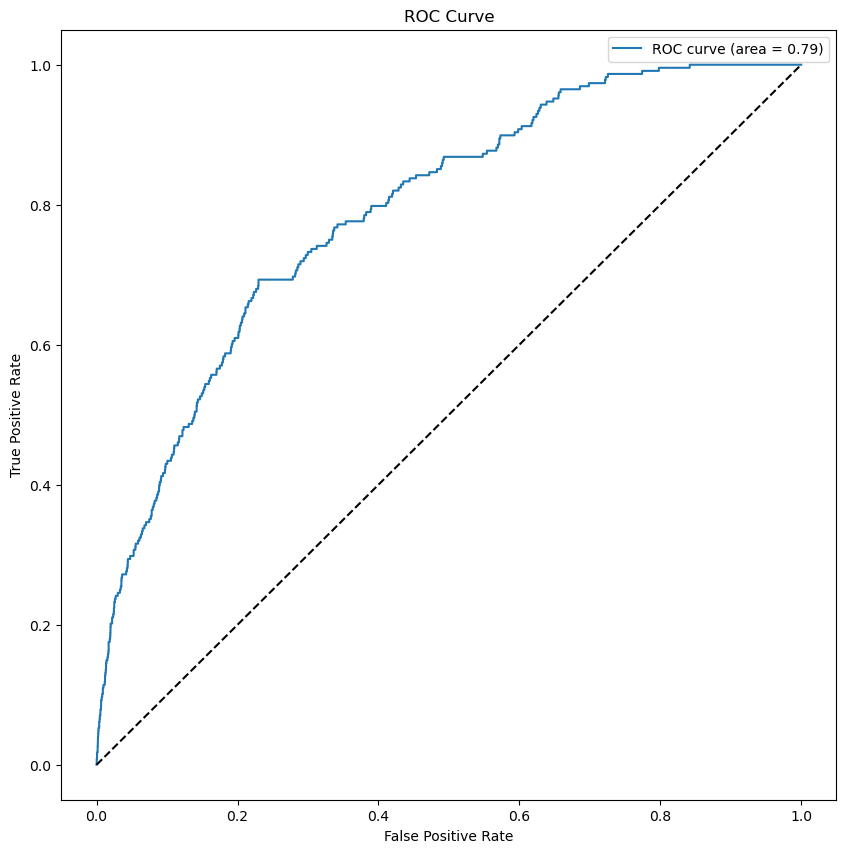

In [31]:
evaluate_model(best_model, X_oot_downsampled, y_oot_downsampled)

ROC AUC on evaluation data: 0.827977261580557


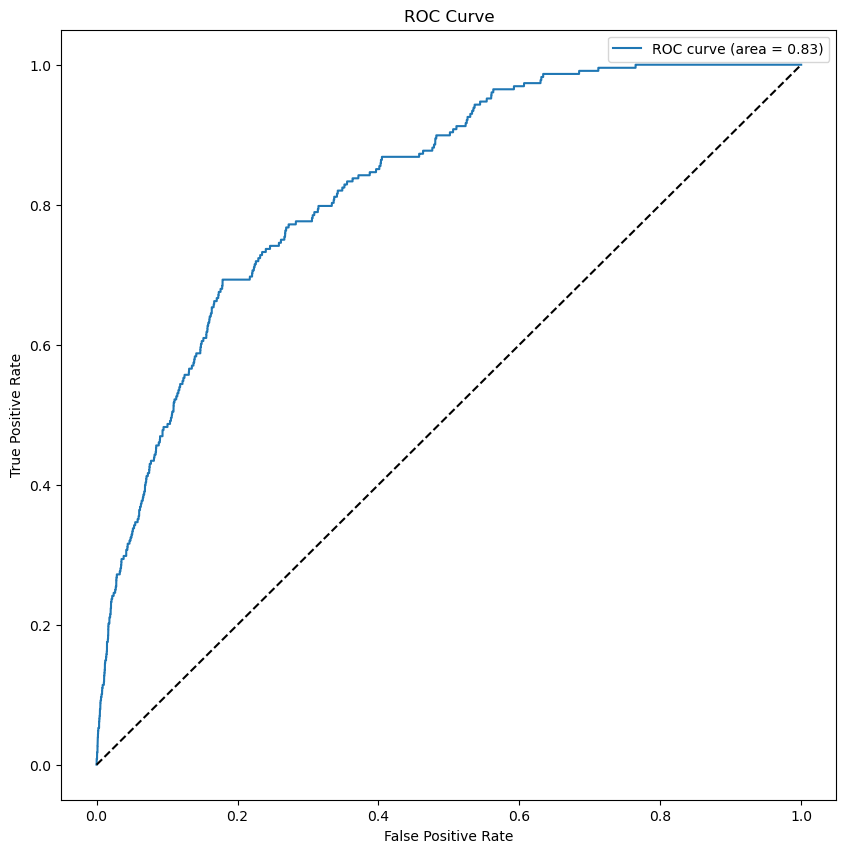

In [32]:
evaluate_model(best_model, X_oot, y_oot)

In [33]:
# print feature importance
feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances)

air_temperature_x                            0.045021
precipitation_amount                         0.032377
air_temperature_y                            0.028248
type_7.0                                     0.026722
type_32.0                                    0.026511
type_9.0                                     0.025629
category                                     0.025199
type_3.0                                     0.025198
type_6.0                                     0.025067
type_29.0                                    0.024874
surface_downwelling_shortwave_flux_in_air    0.024050
slope_avg                                    0.023236
type_12.0                                    0.023173
type_23.0                                    0.022876
type_38.0                                    0.022783
type_1.0                                     0.021989
type_15.0                                    0.021543
type_4.0                                     0.021394
type_25.0                   

old result below before adding slope. no need anymore

c:\Users\fangshuye\AppData\Local\anaconda3\envs\py311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:07:24] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC AUC on OOT data: 0.8003905590653241


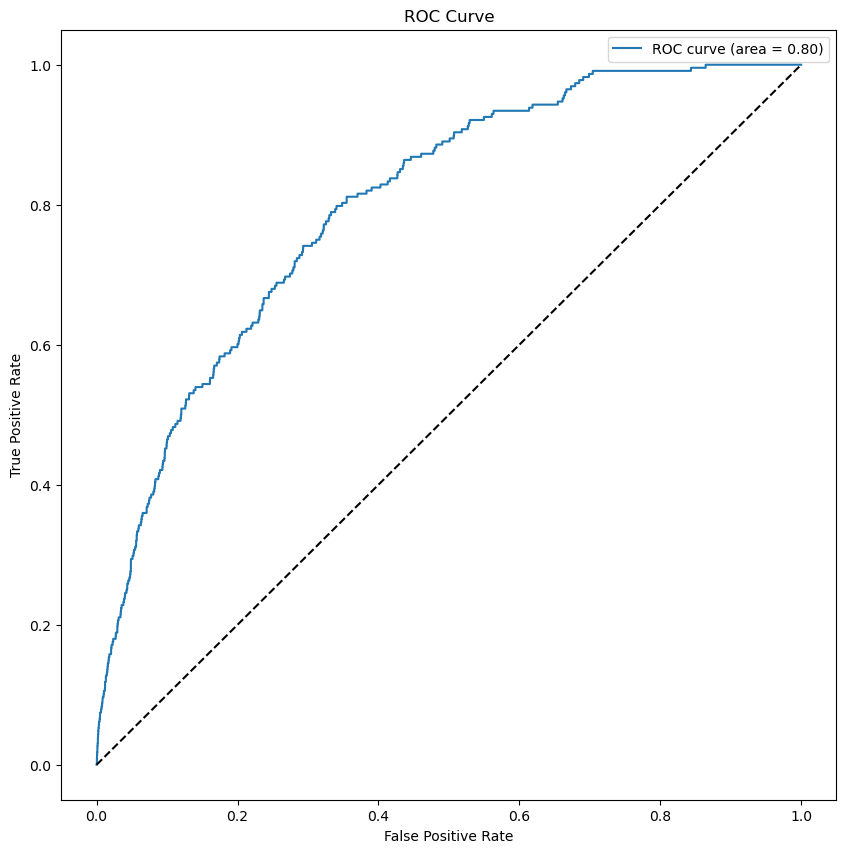

In [70]:
# Train the best model on the full training data
best_model = xgb.XGBClassifier(
    n_estimators=best_params[0],
    max_depth=best_params[1],
    learning_rate=best_params[2],
    subsample=best_params[3],
    use_label_encoder=False,
    eval_metric='logloss'
)
best_model.fit(X_train, y_train)

ROC AUC on OOT data: 0.7693476377420636


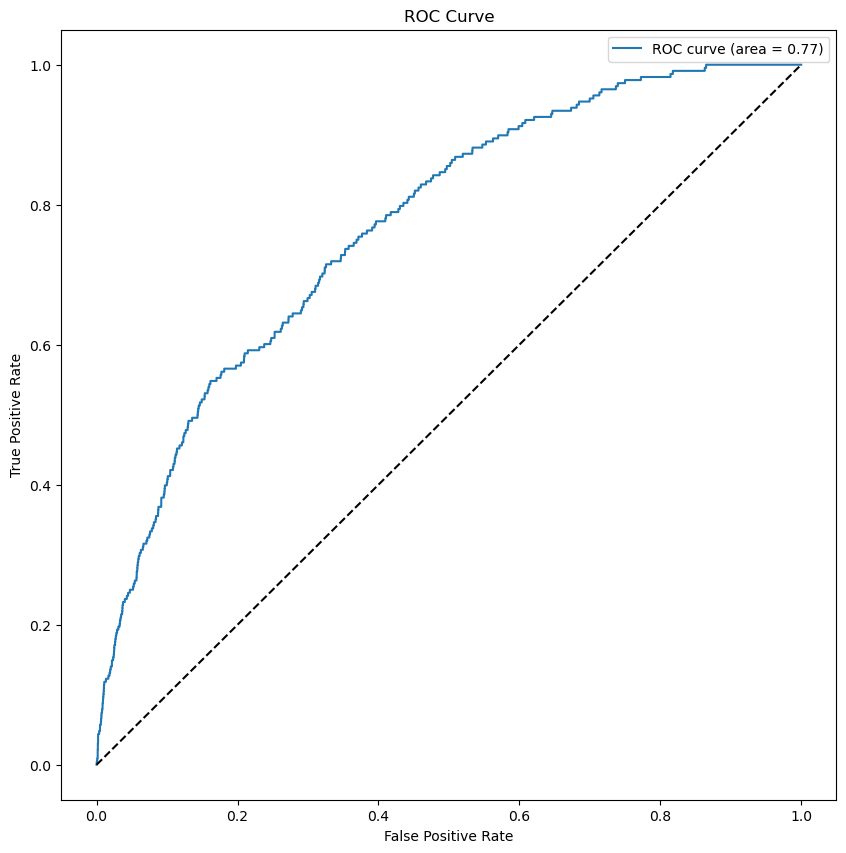

In [66]:
# no parameter tuning

# Predict on OOT data
y_oot_pred = model.predict_proba(X_oot)[:, 1]

# Calculate ROC AUC on OOT data
roc_auc = roc_auc_score(y_oot, y_oot_pred)
print(f'ROC AUC on OOT data: {roc_auc}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_oot, y_oot_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

ROC AUC on OOT data: 0.7429704195341196


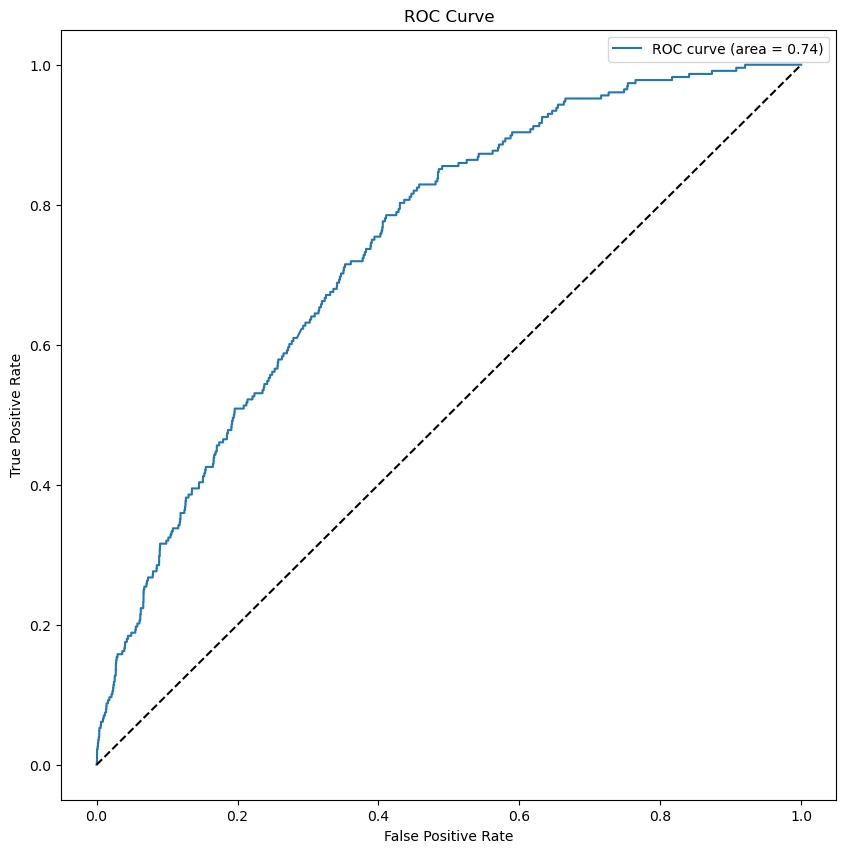

In [ ]:
# no parameter tuning, no veg type in features

# Predict on OOT data
y_oot_pred = model.predict_proba(X_oot)[:, 1]

# Calculate ROC AUC on OOT data
roc_auc = roc_auc_score(y_oot, y_oot_pred)
print(f'ROC AUC on OOT data: {roc_auc}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_oot, y_oot_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()